In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import pickle
import math
import networkx as nx
import numpy as np
import random
import time
import statistics
from itertools import chain 

In [3]:
G1 = nx.read_edgelist('/content/drive/MyDrive/ids_public1 (2).txt')
node_count = len(list(G1.nodes()))
print('Число вершин:', node_count)
print('Число связей:', len(list(G1.edges())))
print('Кластерный коэффициент: ', nx.average_clustering(G1))
all_possible_count = int(node_count*(node_count - 1)/2)
print('Число всех возможных связей: ', all_possible_count)

Число вершин: 6345
Число связей: 139658
Кластерный коэффициент:  0.7346333422439906
Число всех возможных связей:  20126340


In [5]:
L_connected_subgraphs = []
connected_graphs = list((G1.subgraph(c) for c in nx.connected_components(G1)))
for x in connected_graphs:    
    if len(x) < 5:
        continue
    path_length = nx.average_shortest_path_length(x)
    L_connected_subgraphs.append(path_length)
    
L = np.mean(L_connected_subgraphs)
print("Средняя длина пути = ", L)

Средняя длина пути =  2.598616147125738


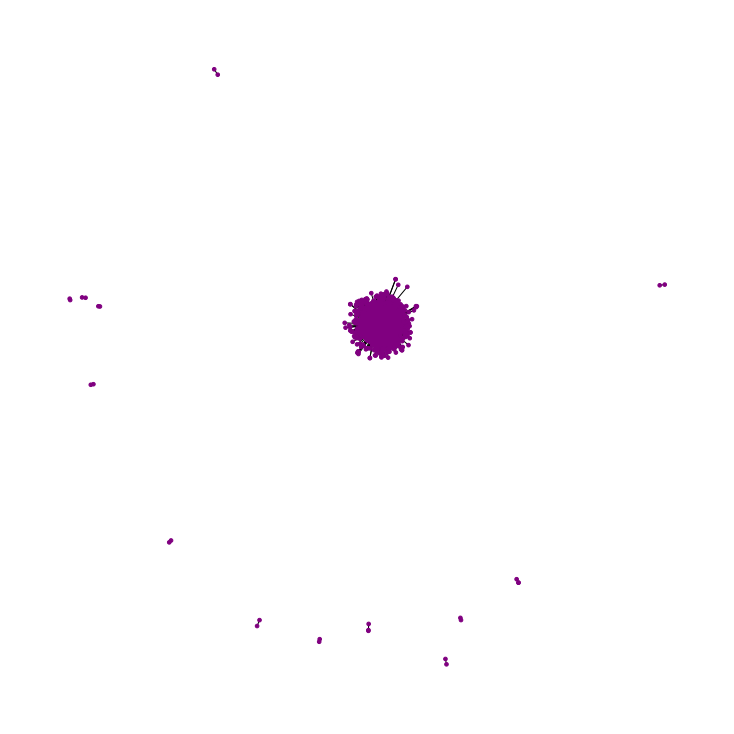

In [56]:
G1_to_draw = G1.subgraph(list(G1.nodes())[:12500])
point_size = 13
point_color = 'purple'
edge_size = 2
color_map = []
for node in G1_to_draw:
    color_map.append(point_color)
size_map = []
for i in nx.get_edge_attributes(G1_to_draw,'weight').values():
    size_map.append(edge_size)

### Как-то отвечает за размер графика
plt.figure(3,figsize=(10,10)) 
###

nx.draw(G1_to_draw, node_size=point_size, node_color=color_map, width=size_map, pos=nx.spring_layout(G1_to_draw))
plt.show()

In [7]:
# Функция построения графика распределения степеней вершин в графе
def draw_nodes_degree_distribution(G):
    degree = dict(G.degree())
    degree_values = sorted(set(degree.values()))
    hist = [list(degree.values()).count(x) for x in degree_values]
    plt.plot(degree_values, hist, 'ro-')
    plt.xlabel("Количество связей")
    plt.ylabel("Количество вершин")
    plt.title("Распределение степеней графов")

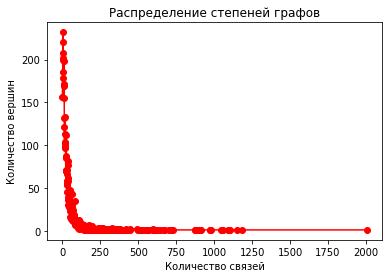

In [8]:
draw_nodes_degree_distribution(G1)

In [51]:
# Получение коэффициентов схожести графа с моделью Малого мира
def small_world_similarity(G):
    L_s, C_s = [], []

    ### исходные параметры
    L = 2.598616147125738
    C = 0.7346333422439906
    ###

    for i in range(1):
        connected_components_count = 10
        while connected_components_count != 1:

            ### 2 и 3 параметры изменяемые
            generated_G = nx.watts_strogatz_graph(len(G), 45, 0.2)
            ###

            A = (generated_G.subgraph(c) for c in nx.connected_components(generated_G))
            A = list(A)            
            connected_components_count = len(A)
            
        print("Связи исходные = ", nx.number_of_edges(G), "Связи сгенерированные = ", nx.number_of_edges(generated_G))        
        L_s_ = nx.average_shortest_path_length(generated_G)
        C_s_ = nx.average_clustering(generated_G)
        print("L_mm = ", L_s_)
        print("C_mm = ", C_s_)
        L_s.append(L_s_)
        C_s.append(C_s_)
        draw_nodes_degree_distribution(generated_G)
    
    lambda_ = L / np.mean(L_s)
    gamma_ = C / np.mean(C_s)
    return generated_G

Связи исходные =  139658 Связи сгенерированные =  139590
L_mm =  2.912626736902984
C_mm =  0.37606841153461534


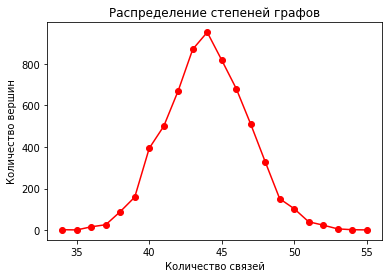

In [52]:
cmWorld = small_world_similarity(G1)

In [47]:
# Получение коэффициентов схожести графа с моделью Эрдоша-Реньи (случайный граф)
def erdos_renyi_similarity(G):
    er_graph = nx.erdos_renyi_graph(len(G), p=node_count/all_possible_count) 
    draw_nodes_degree_distribution(er_graph)
    L_connected_subgraphs = []
    connected_graphs = list((er_graph.subgraph(c) for c in nx.connected_components(er_graph)))
    for x in connected_graphs:
        path_length = nx.average_shortest_path_length(x)
        L_connected_subgraphs.append(path_length)
    
    L = np.mean(L_connected_subgraphs)
    C = nx.average_clustering(er_graph)
    print("L_er = ", L)
    print("С_er = ", C)

    plt.show()

L_er =  0.21342300567250755
С_er =  0.0002649255131524635


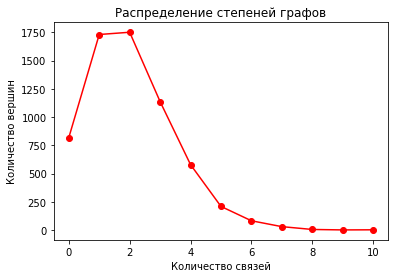

In [48]:
erdos_renyi_similarity(G1)

In [40]:
def barabasi_albert_similarity(G):
    ### 2 параметр изменяемый
    ba_graph = nx.barabasi_albert_graph(len(G), 31)
    ###
    L = nx.average_shortest_path_length(ba_graph)
    C = nx.average_clustering(ba_graph)
    draw_nodes_degree_distribution(ba_graph)
    print('L_ba =', L)
    print('C_ba =', C)
    print('Связи = ', len(list(ba_graph.edges())))
    return ba_graph

L_ba = 2.442363539520847
C_ba = 0.034633447111514004
Связи =  195734


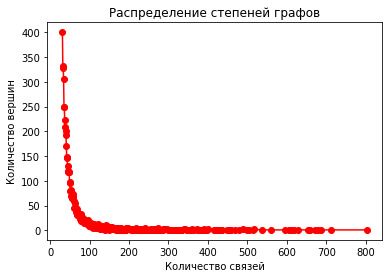

In [41]:
baGraph = barabasi_albert_similarity(G1)

In [43]:
### Свои значения - исходные и рассчитанные
L = 2.598616147125738
C = 0.7346333422439906
E = 139658

Cm = 0.3792563399918787
Lm = 2.915939013253279
Em = 139590

Cb = 0.034633447111514004
Lb = 2.442363539520847
Eb = 195734

# параметр = 5
# Cb = 0.005469077321709941
# Lb = 3.7570533908347663
# Eb = 73810

# параметр = 10
# Cb = 0.008064410685928808
# Lb = 3.1597141497058634
# Eb = 147570
### 

In [44]:
def otnos_error(fact, approx):
    return abs(fact-approx)/fact

In [45]:
# baGraph, cmWorld
degreeBA = dict(baGraph.degree())
degree_valuesBA = sorted(set(degreeBA.values()))
histBA = [list(degreeBA.values()).count(x) for x in degree_valuesBA]

degreeSW = dict(cmWorld.degree())
degree_valuesSW = sorted(set(degreeSW.values()))
histSW = [list(degreeSW.values()).count(x) for x in degree_valuesSW]

degree = dict(G1.degree())
degree_values = sorted(set(degree.values()))
hist = [list(degree.values()).count(x) for x in degree_values]

sum = 0
for x in range(201):
    if x not in degree_values:
        continue
    if x not in degree_valuesBA:
        valueBA = 0
    else:
        indexBA = degree_valuesBA.index(x)
        valueBA = histBA[indexBA]
    value_real = hist[degree_values.index(x)]
    sum += otnos_error(value_real, valueBA)
Eba = sum / 200
print(Eba)

sum = 0
for x in range(201):
    if x not in degree_values:
        continue
    if x not in degree_valuesSW:
        valueSW = 0
    else:
        indexSW = degree_valuesSW.index(x)
        valueSW = histSW[indexSW]
    value_real = hist[degree_values.index(x)]
    sum += otnos_error(value_real, valueSW)
Esw = sum / 200
print(Esw)

1.1429338722988873
1.7541636418081372


In [46]:
EEsw = otnos_error(C, Cm) + otnos_error(L, Lm) + otnos_error(E, Em) + Esw
EEba = otnos_error(C, Cb) + otnos_error(L, Lb) + otnos_error(E, Eb) + Eba
print('EEsw=', EEsw)
print('EEba=', EEba)

EEsw= 2.3605102410177556
EEba= 2.557442901007365
